In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from datetime import timedelta
from scipy.stats import norm
from tabulate import tabulate

# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [2]:
df = get_data("^GSPC")
df.to_csv("df.csv")
df = df.drop('ticker', axis=1)
df.head()

,open,high,low,close,adjclose,volume
1970-03-25,0.0,91.070000,88.110001,89.769997,89.769997,17500000
1970-03-26,0.0,90.650002,89.180000,89.919998,89.919998,11350000
1970-03-30,0.0,90.410004,88.910004,89.629997,89.629997,9600000
1970-03-31,0.0,90.169998,88.849998,89.629997,89.629997,8370000
1970-04-01,0.0,90.620003,89.300003,90.070000,90.070000,9810000


In [3]:
df.describe()


,open,high,low,close,adjclose,volume
count,13571.000000,13571.000000,13571.000000,13571.000000,13571.000000,1.357100e+04
mean,1034.335500,1063.489503,1050.449024,1057.392072,1057.392072,1.578465e+09
std,1133.273650,1119.228326,1106.540983,1113.282064,1113.282064,1.869645e+09
min,0.000000,63.230000,60.959999,62.279999,62.279999,6.650000e+06
25%,157.904999,158.580002,157.115005,157.985001,157.985001,8.101000e+07
50%,754.849976,758.340027,747.710022,754.849976,754.849976,4.717400e+08
75%,1397.020020,1404.414978,1386.599976,1397.700012,1397.700012,3.278855e+09
max,4804.509766,4818.620117,4780.979980,4796.560059,4796.560059,1.145623e+10


# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

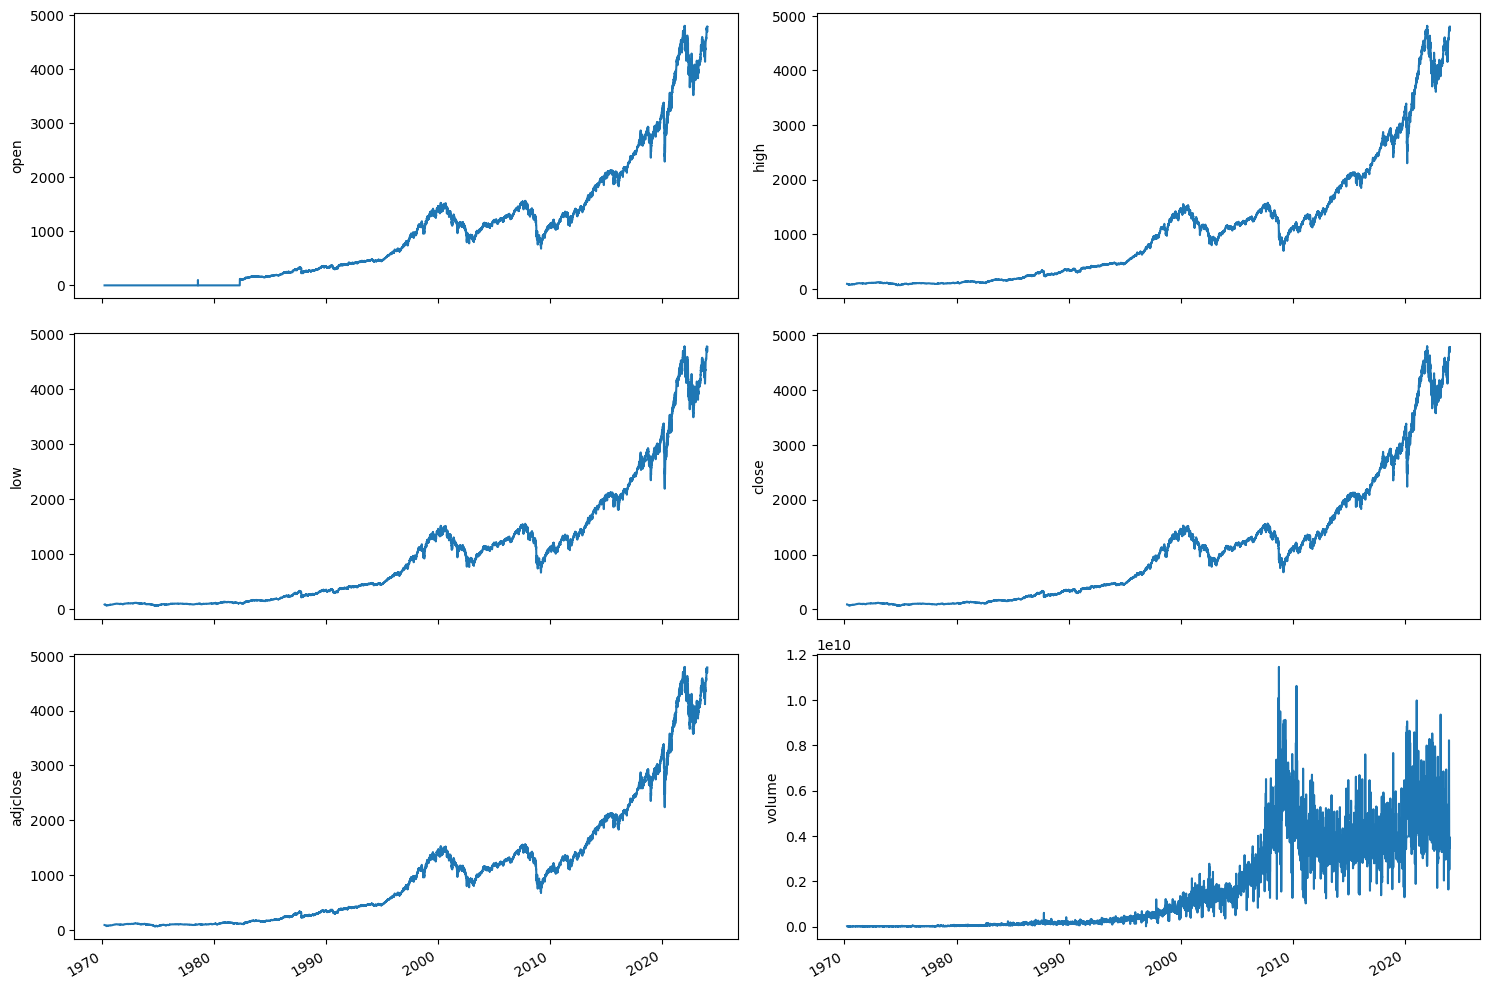

In [4]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

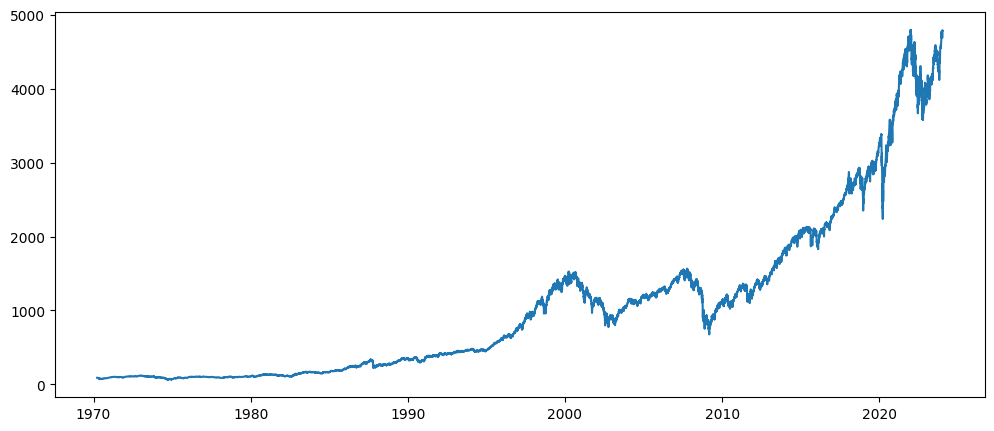

In [5]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [6]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

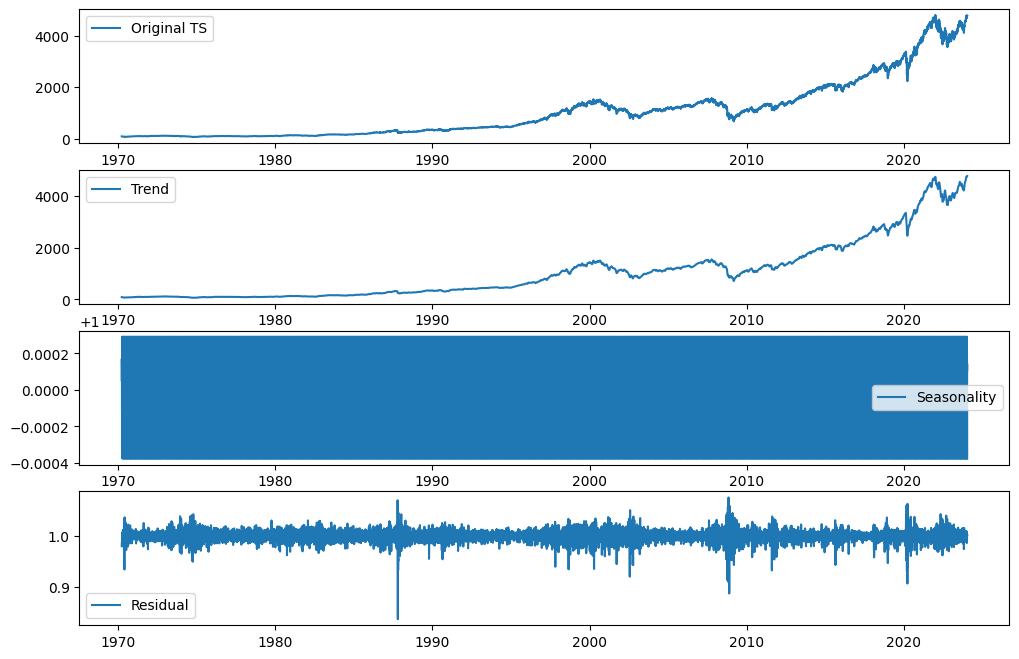

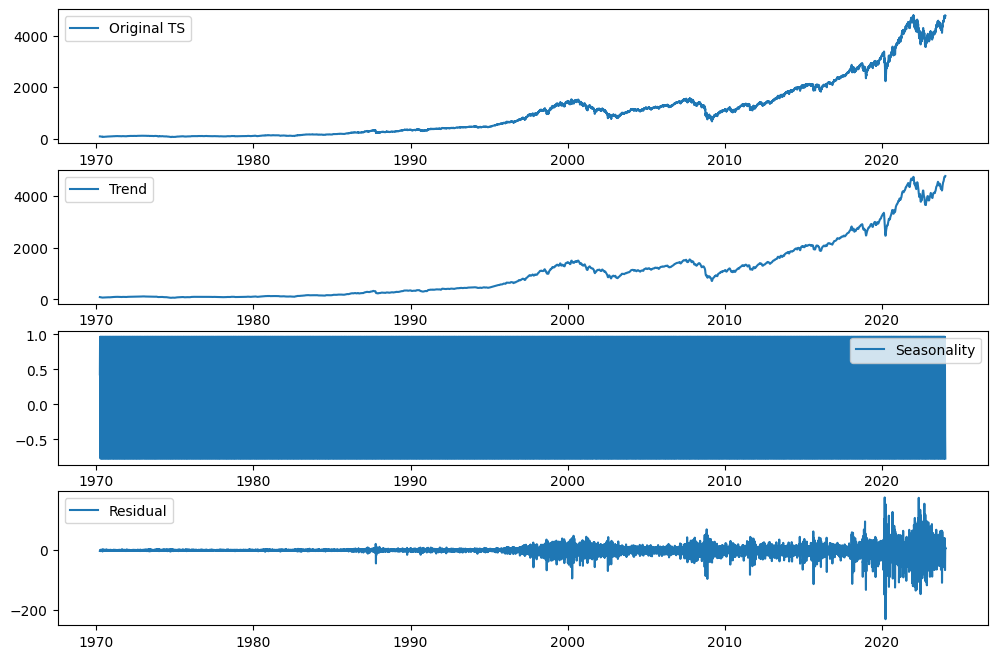

In [7]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

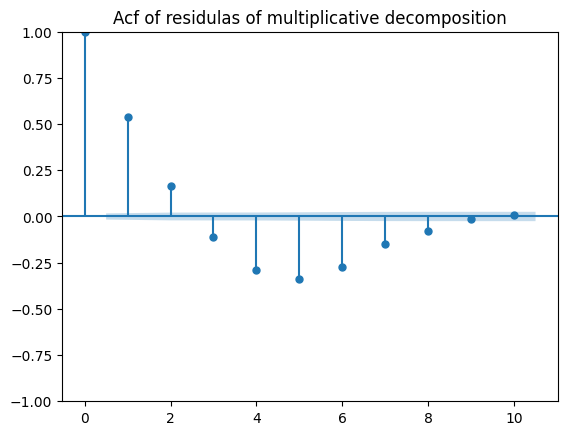

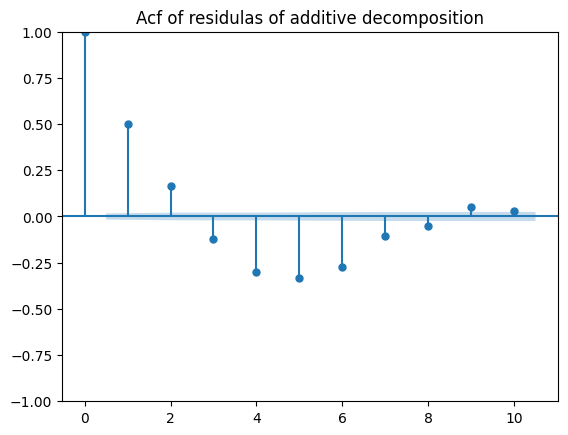

In [8]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

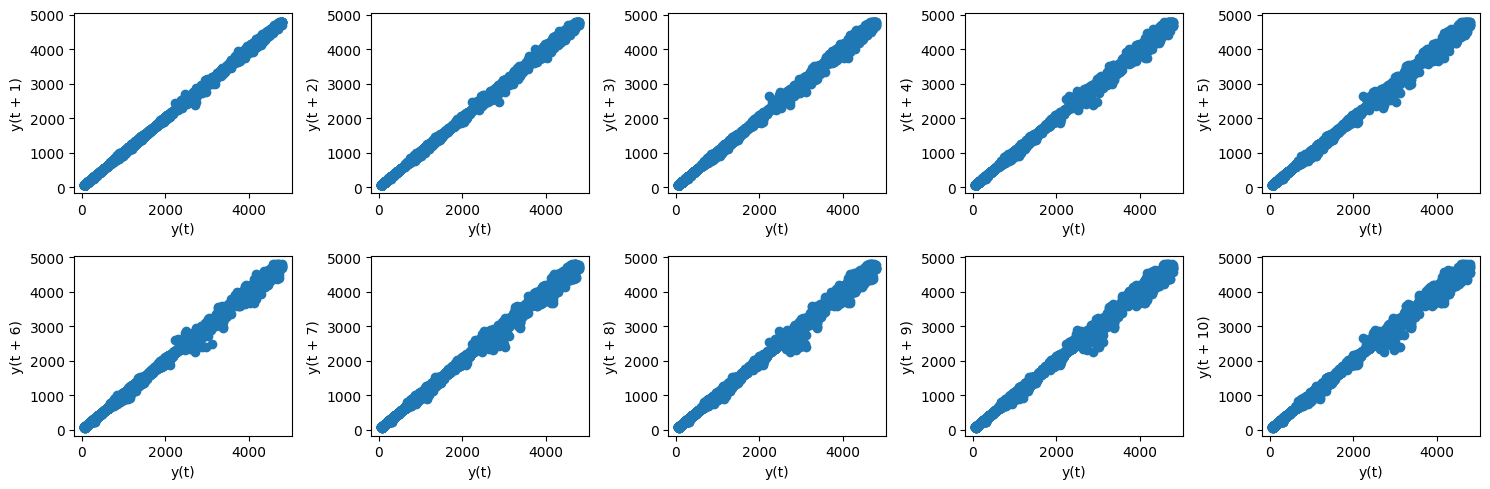

In [9]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

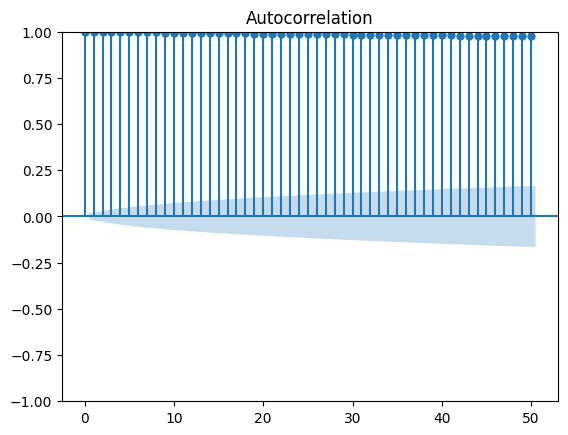

[1.         0.99943969 0.99890082 0.99835306 0.99781471 0.9972826
 0.99676121 0.99625769 0.99573124 0.9952145  0.99466871]


In [10]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [11]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


,open,high,low,close,adjclose,volume
count,13570.000000,13570.000000,13570.000000,13570.000000,13570.000000,1.357000e+04
mean,0.353071,0.347187,0.344943,0.345915,0.345915,2.556256e+05
std,15.679420,13.587431,15.350416,17.218764,17.218764,4.459665e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.699982,-1.537491,-1.680006,-1.867523,-1.867523,-3.936000e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969994,2.500000,2.869995,2.937469,2.937469,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


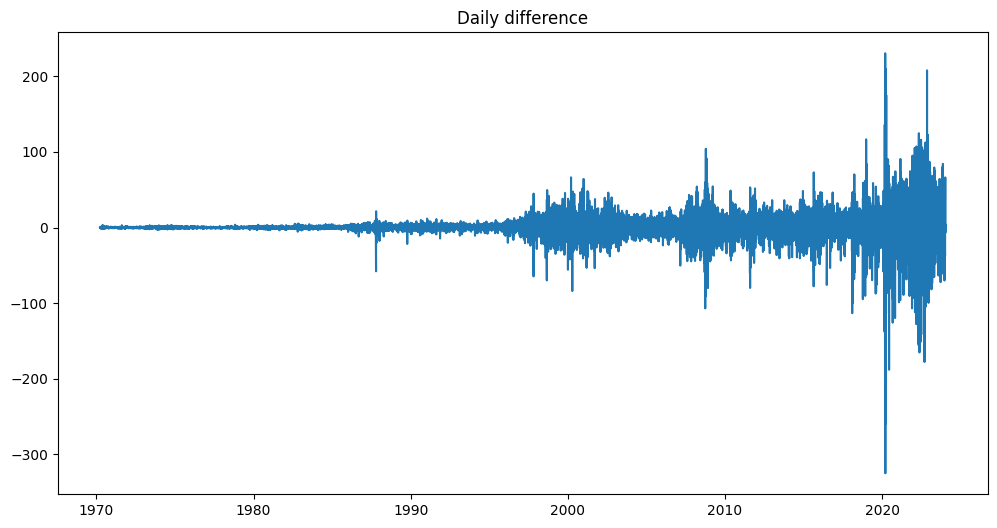

In [12]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [13]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -20.01825200042903
p-value: 0.0
Critical Values: {'1%': -3.430833481761374, '5%': -2.861753676315736, '10%': -2.5668837350416474}
The time series is stationary.


KPSS Statistic: 0.7654787651635344
p-value: 0.01
The time series is non-stationary.


C:\Users\GODA\AppData\Local\Temp\ipykernel_6304\3128835151.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_diff[var])


## ACF of daily differences

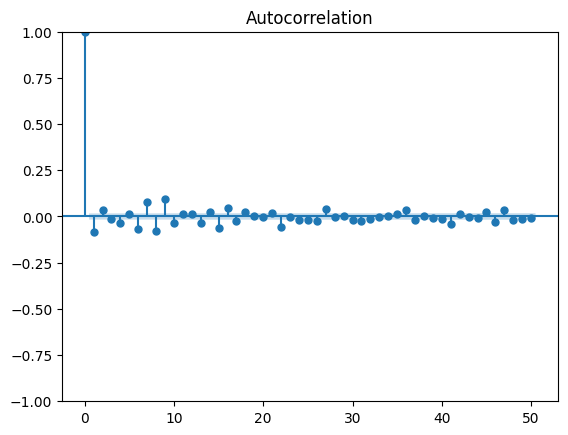

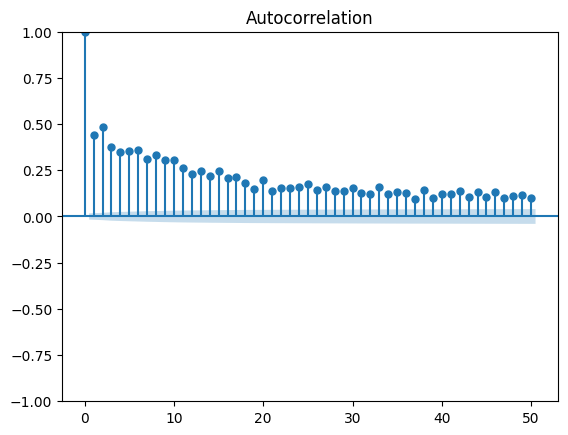

In [14]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

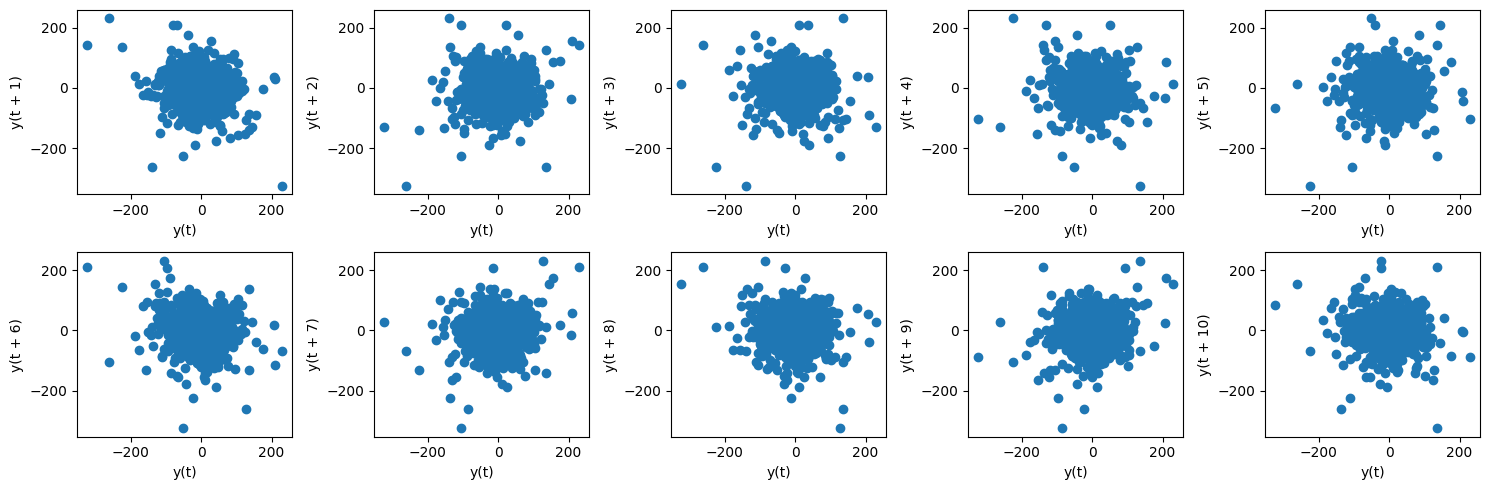

In [15]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

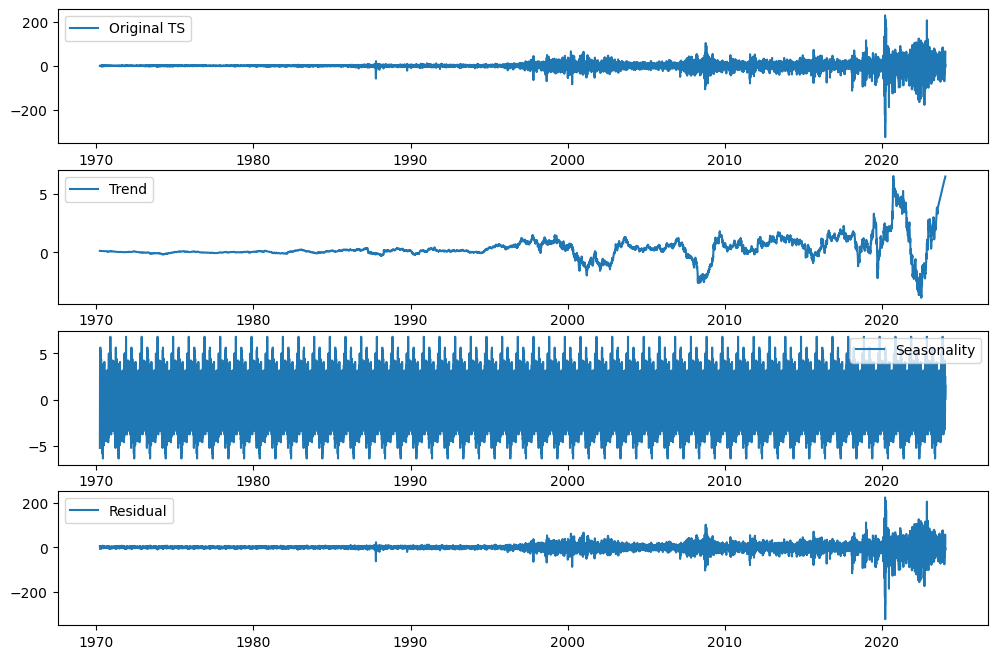

In [16]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

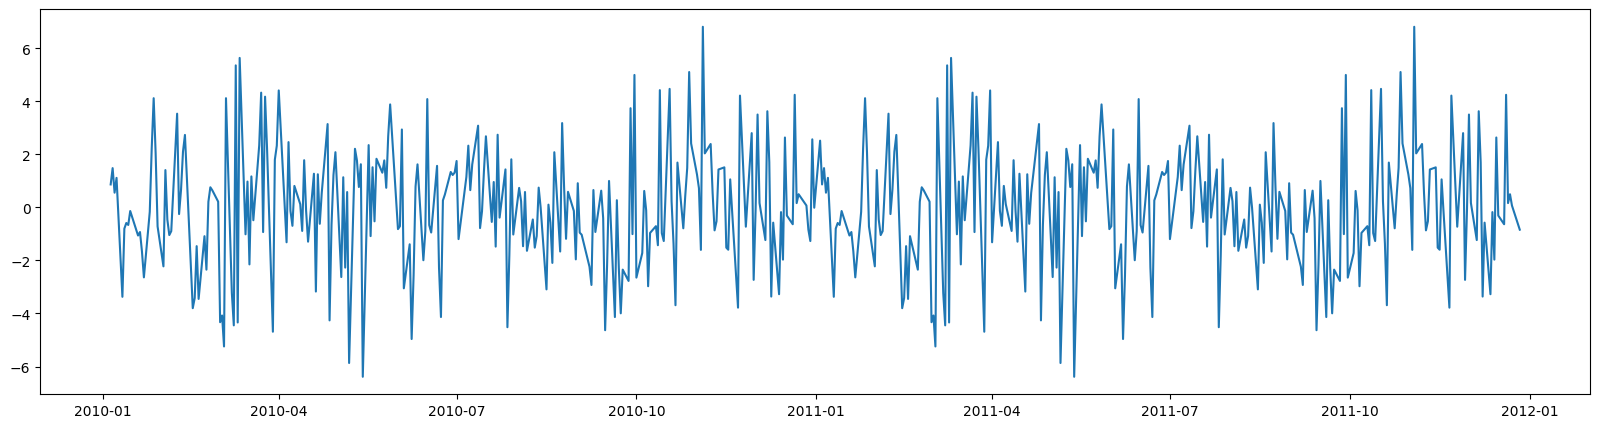

In [17]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

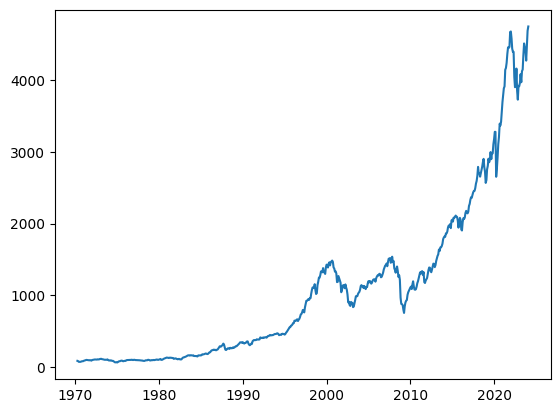

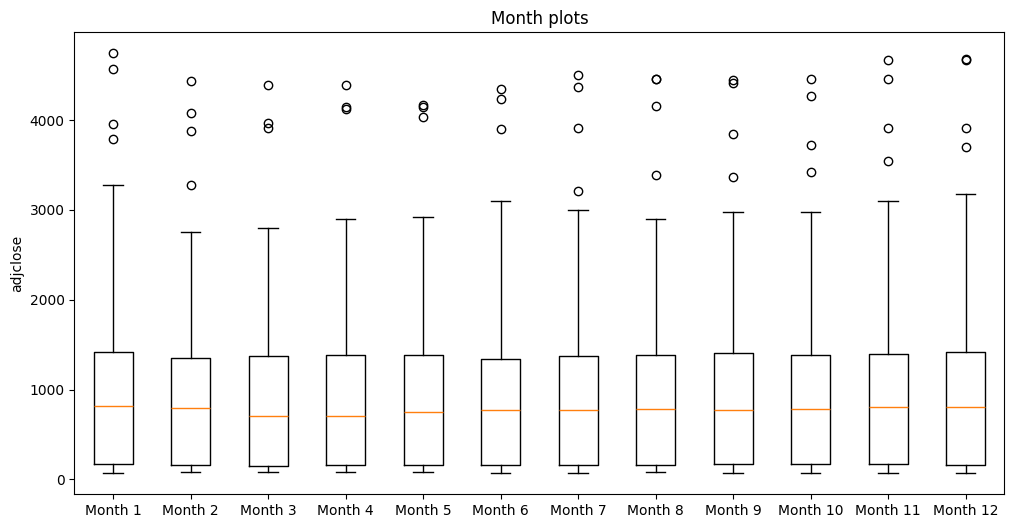

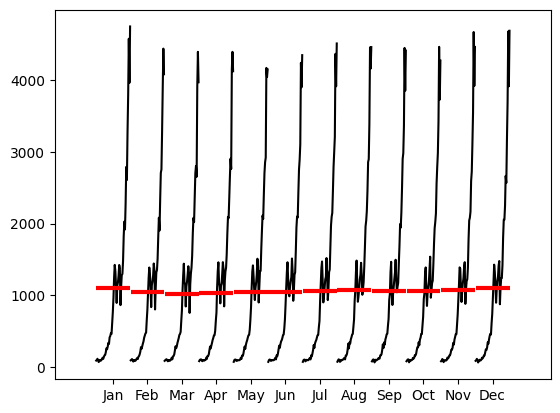

In [18]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

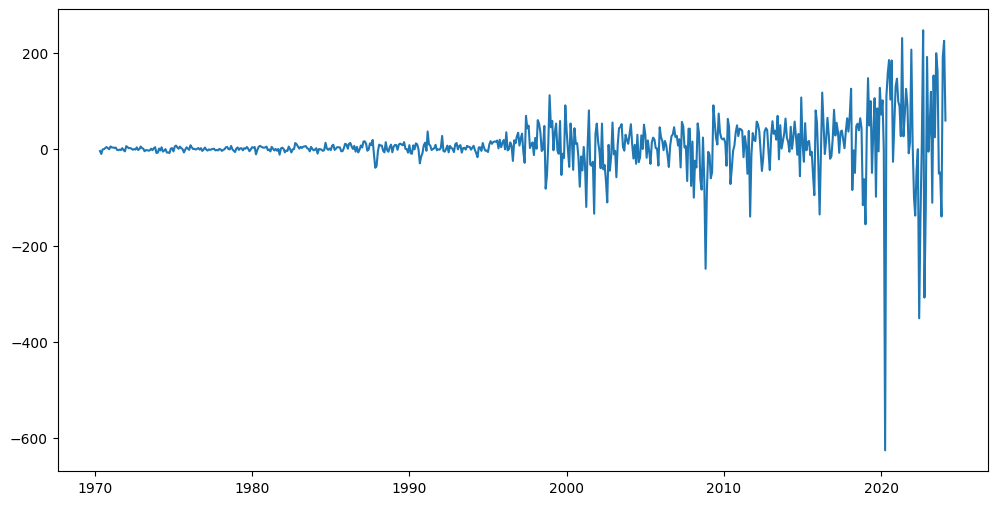

In [19]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

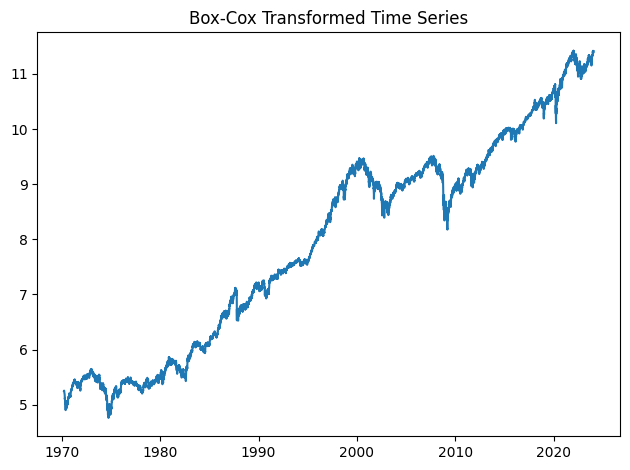

Optimal lambda value: 0.06717870170250584


In [20]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

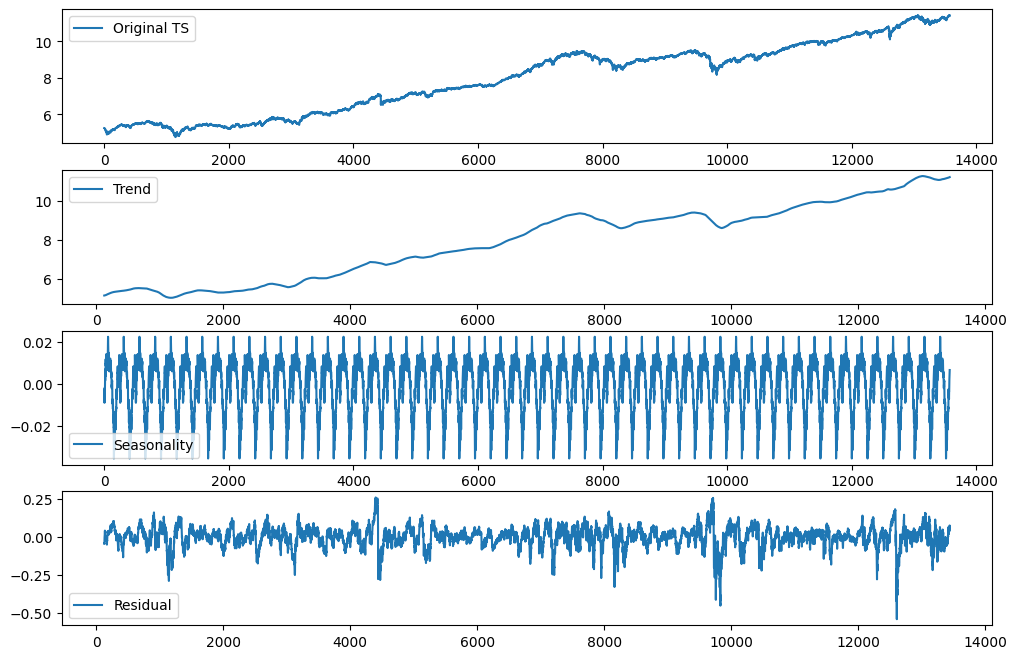

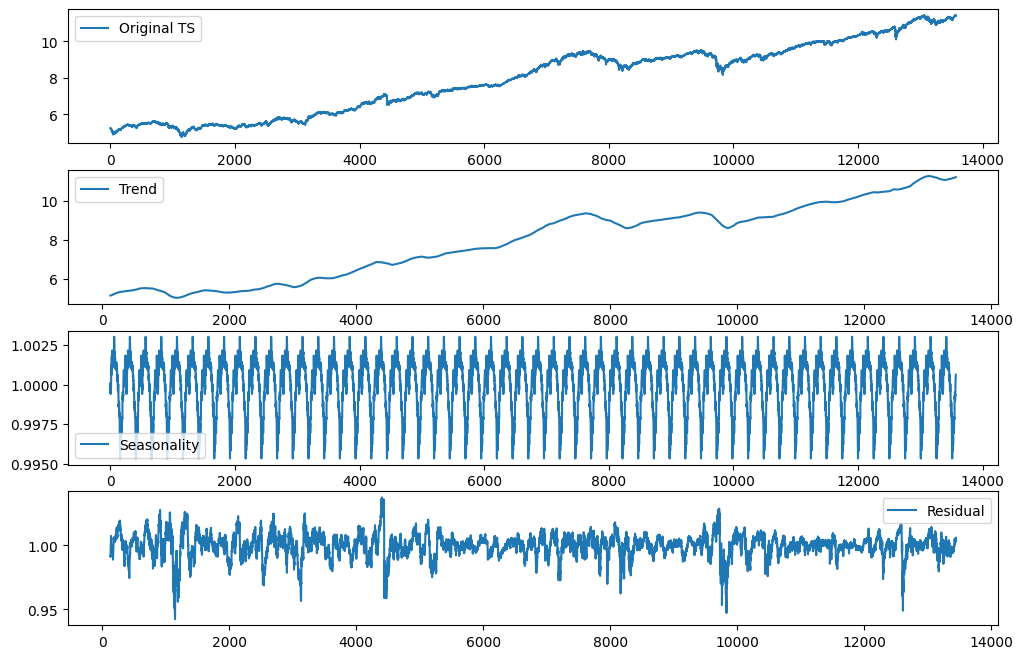

In [21]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

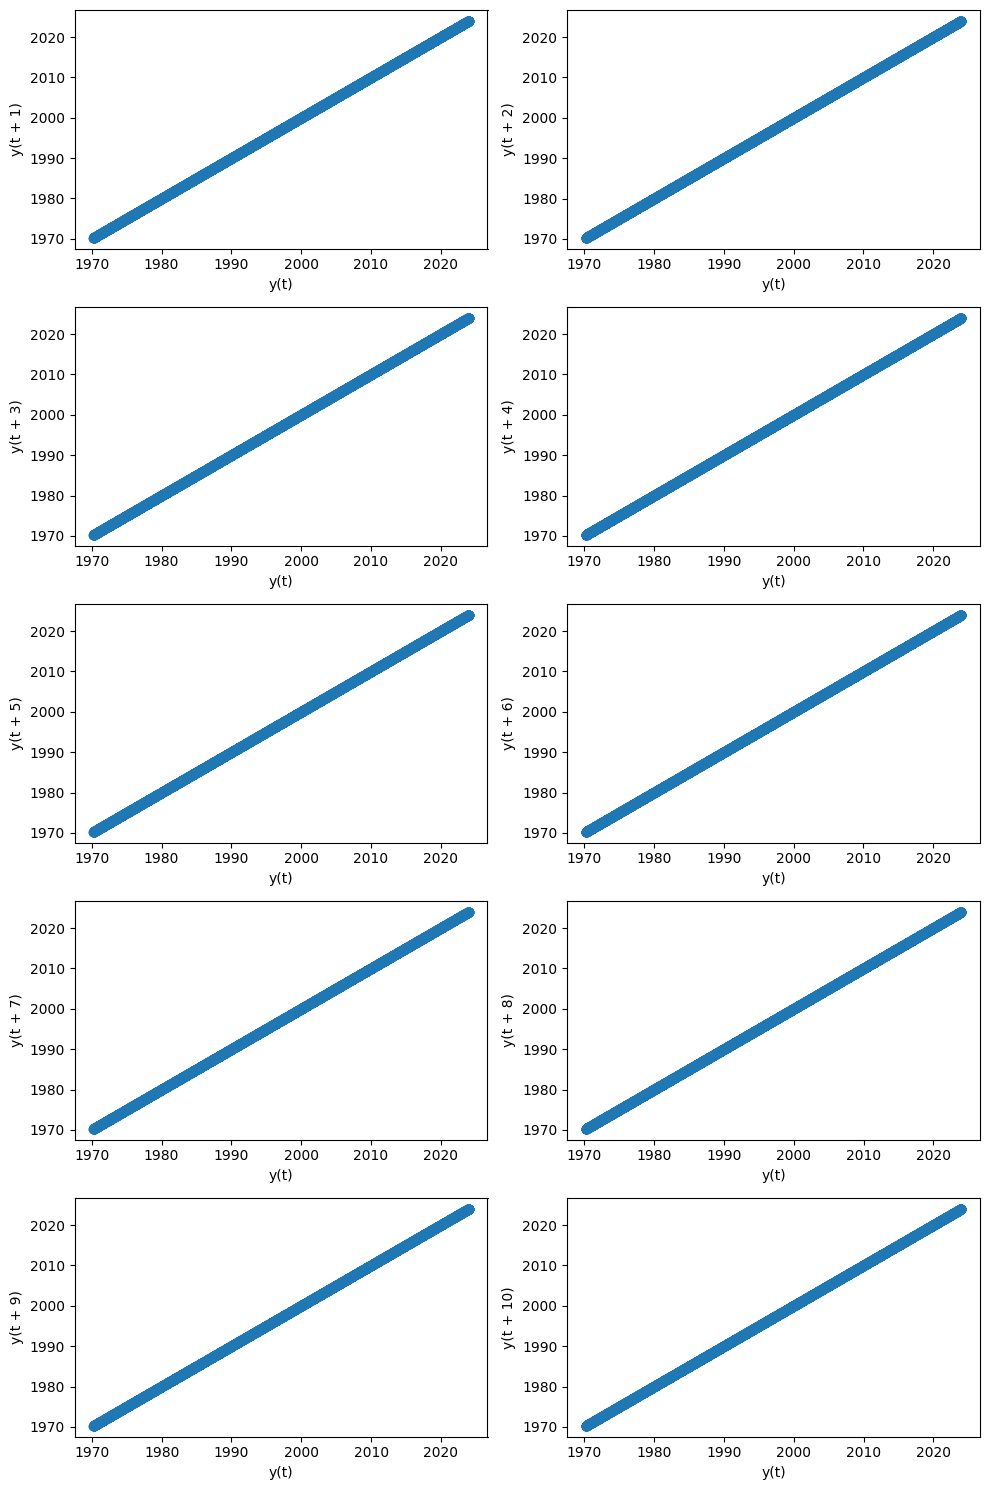

In [22]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

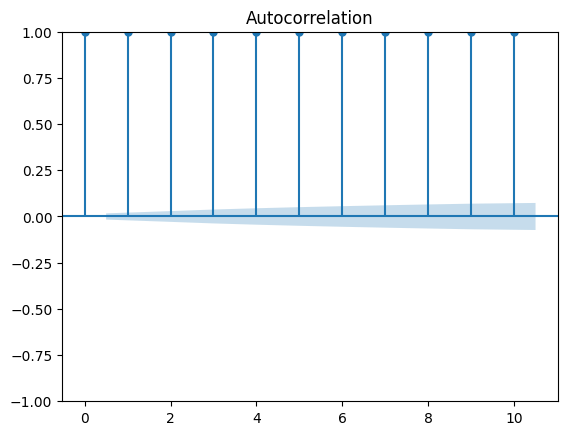

In [23]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [24]:
daily_diff.describe()

,open,high,low,close,adjclose,volume
count,13570.000000,13570.000000,13570.000000,13570.000000,13570.000000,1.357000e+04
mean,0.353071,0.347187,0.344943,0.345915,0.345915,2.556256e+05
std,15.679420,13.587431,15.350416,17.218764,17.218764,4.459665e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.699982,-1.537491,-1.680006,-1.867523,-1.867523,-3.936000e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969994,2.500000,2.869995,2.937469,2.937469,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


# Model

Conditional Variance:

The GARCH model assumes that the variance of the financial time series is not constant over time but depends on past observations. The conditional variance at each time point is the estimated volatility given the available information up to that point.

Volatility:

In the GARCH context, volatility is often used interchangeably with conditional variance. It characterizes the magnitude of potential fluctuations in the returns of a financial asset.

In [25]:
returns = df['adjclose'].pct_change()
returns = returns[1:] *100
print(returns)
returns_sqr = list(map(lambda x:x*x,returns))

1970-03-26    0.167095
1970-03-30   -0.322510
1970-03-31    0.000000
1970-04-01    0.490910
1970-04-02   -0.310868
                ...   
2024-01-08    1.411463
2024-01-09   -0.147790
2024-01-10    0.566597
2024-01-11   -0.067106
2024-01-12    0.075098
Name: adjclose, Length: 13570, dtype: float64


Returns


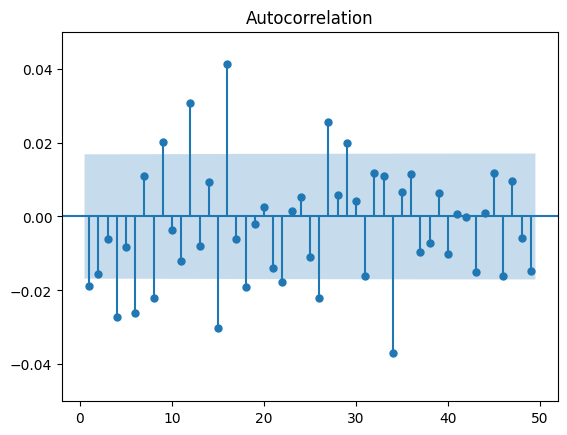

[ 1.         -0.01881314 -0.01568267 -0.00611137 -0.0270704  -0.0083024
 -0.02621505  0.01094941 -0.02209288  0.0201564  -0.00361011]


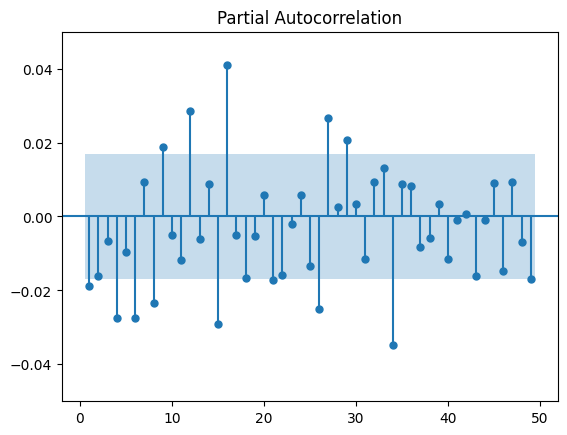

[ 1.         -0.01881452 -0.01604465 -0.00671854 -0.02759409 -0.00957908
 -0.02754475  0.00925243 -0.02354074  0.01880377 -0.00510282]


In [26]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns,nlags=10)
fig = tsaplots.plot_pacf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Returns square


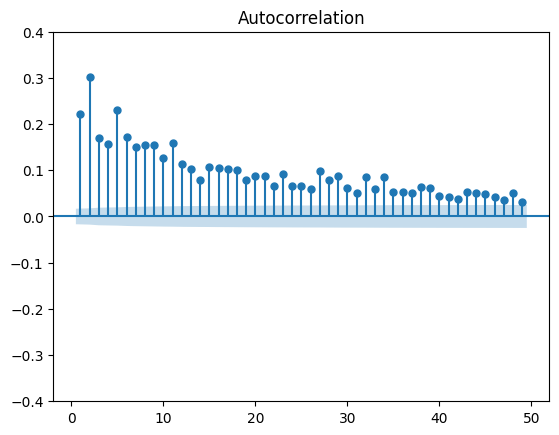

[1.         0.22139111 0.30176572 0.16881408 0.15719318 0.23098238
 0.17192651 0.15129227 0.15471352 0.1553843  0.12712381]


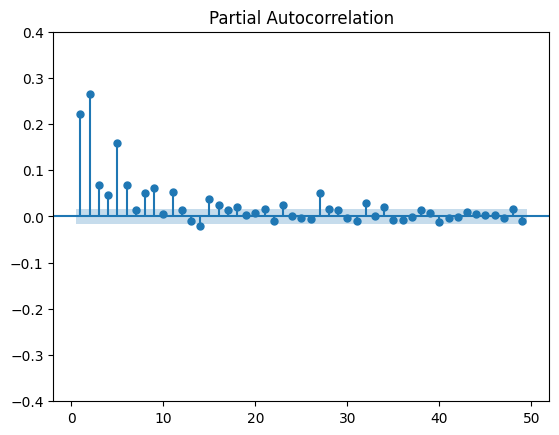

[1.         0.22140743 0.26581978 0.06894999 0.04635904 0.15818526
 0.06797671 0.01390027 0.05030683 0.06209732 0.00599172]


In [27]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

The ACF and PACF of the returns are similar to white nois white noise but have more correlation.

The ACF and PACF of the squared returns appear to be from an AR(2) model in that the PACF cuts off at lag 2, whereas the ACF is tailing off.

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


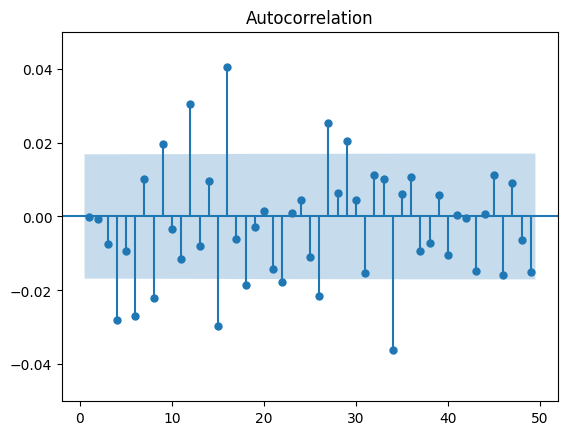

[ 1.00000000e+00 -1.08644647e-04 -5.58511570e-04 -7.39613706e-03
 -2.80645980e-02 -9.28316962e-03 -2.69864911e-02  1.02154005e-02
 -2.19939432e-02  1.96549217e-02 -3.33534856e-03]


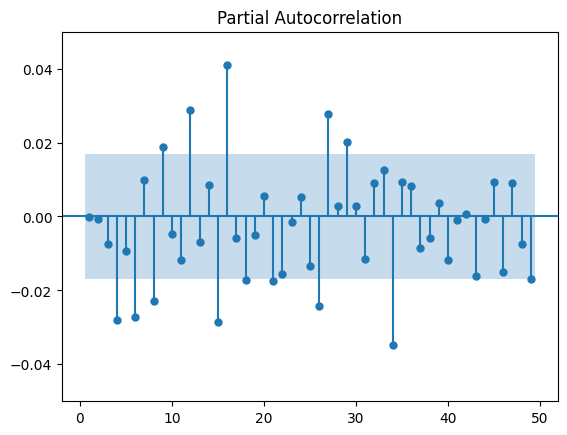

[ 1.00000000e+00 -1.08652655e-04 -5.58605722e-04 -7.39789659e-03
 -2.80763710e-02 -9.31488519e-03 -2.71186243e-02  9.77178254e-03
 -2.30148634e-02  1.87890905e-02 -4.87571255e-03]


In [28]:
model_ar = AutoReg(returns,lags=2)
results = model_ar.fit()

acf= sm.tsa.acf(results.resid,nlags=10)
fig = tsaplots.plot_acf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(results.resid,nlags=10)
fig = tsaplots.plot_pacf(results.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 221902917278959.75
Iteration:      2,   Func. Count:     13,   Neg. LLF: 7521765517.499418
Iteration:      3,   Func. Count:     19,   Neg. LLF: 20434.74490546363
Iteration:      4,   Func. Count:     25,   Neg. LLF: 19476.89529157636
Iteration:      5,   Func. Count:     30,   Neg. LLF: 19437.260426167806
Iteration:      6,   Func. Count:     34,   Neg. LLF: 19437.26040159676
Iteration:      7,   Func. Count:     37,   Neg. LLF: 19437.260401596744
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19437.26040159676
            Iterations: 7
            Function evaluations: 37
            Gradient evaluations: 7


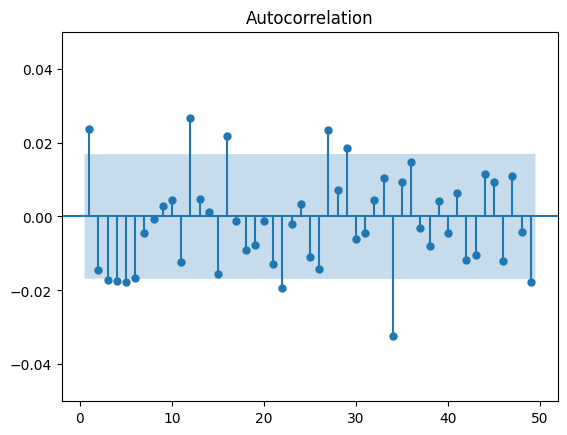

[ 1.00000000e+00  2.35805355e-02 -1.45043029e-02 -1.70565856e-02
 -1.75135984e-02 -1.77029729e-02 -1.67700721e-02 -4.58806900e-03
 -5.89053730e-04  2.90787906e-03  4.46712248e-03]


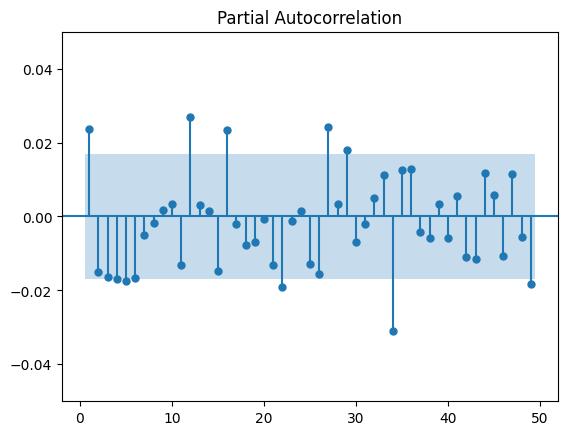

[ 1.          0.02358227 -0.01507095 -0.01637052 -0.0169593  -0.01740901
 -0.01676841 -0.00491841 -0.00175646  0.00166251  0.0032994 ]


In [29]:
model_arch = arch_model(returns,vol="ARCH",p=1)
result = model_arch.fit()

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 609123863050.033
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7565308569.406445
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.530818423093
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17800.324935471537
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.357528218177
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21593.17565028564
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.746146365098
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.76218536861
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.759887532964
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.759878840363
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.759878836885
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.759878840363
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

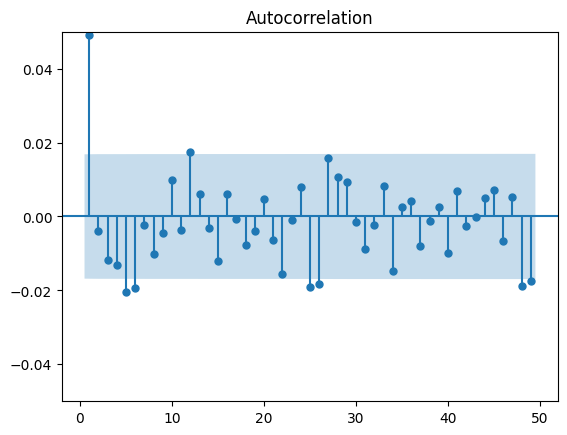

[ 1.          0.04917065 -0.00396287 -0.01172473 -0.01326283 -0.02049823
 -0.01943667 -0.00229262 -0.01007881 -0.0044713   0.00973561]


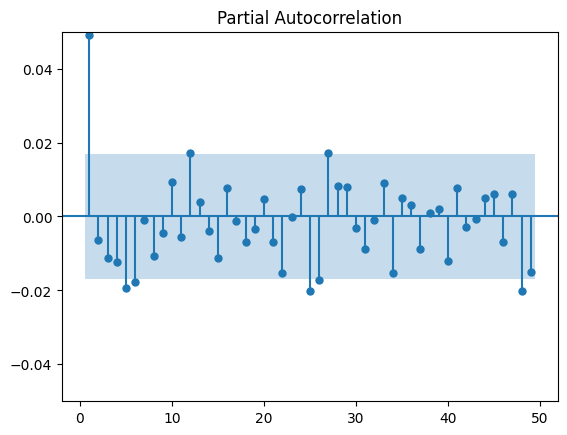

[ 1.00000000e+00  4.91742780e-02 -6.39703049e-03 -1.12442526e-02
 -1.21889414e-02 -1.94172002e-02 -1.77919304e-02 -9.56534699e-04
 -1.07492801e-02 -4.39592517e-03  9.22504253e-03]


In [30]:
model_garch = arch_model(returns,vol="GARCH",p=1,q=1)
result = model_garch.fit()

acf= sm.tsa.acf(result.std_resid,nlags=10)
tsaplots.plot_acf(result.std_resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.std_resid,nlags=10)
tsaplots.plot_pacf(result.std_resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

After this analysis lets compare some garch models to make sure that we have the best fitt for our data

In [31]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit()

model2 = arch_model(returns,vol="GARCH",p=2,q=1)
results2 = model2.fit()

model3 = arch_model(returns,vol="GARCH",p=3,q=1)
results3 = model3.fit()

model4 = arch_model(returns,vol="GARCH",p=4,q=1)
results4 = model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 609123863050.033
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7565308569.406445
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.530818423093
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17800.324935471537
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.357528218177
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21593.17565028564
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.746146365098
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.76218536861
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.759887532964
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.759878840363
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.759878836885
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.759878840363
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

In [32]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35515.519757680726
35517.51975765371
35519.51975760475
35521.51975736351
35545.58222469204
35555.09784141785
35564.61345812173
35574.12907463331
-17753.759878840363
-17753.759878826855
-17753.759878802375
-17753.759878681754


In [33]:
model1 = arch_model(returns,vol="GARCH",p=1,q=1)
results1 = model1.fit()

model2 = arch_model(returns,vol="GARCH",p=1,q=2)
results2 = model2.fit()

model3 = arch_model(returns,vol="GARCH",p=1,q=3)
results3 = model3.fit()

model4 = arch_model(returns,vol="GARCH",p=1,q=4)
results4 = model4.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 609123863050.033
Iteration:      2,   Func. Count:     16,   Neg. LLF: 7565308569.406445
Iteration:      3,   Func. Count:     24,   Neg. LLF: 17895.530818423093
Iteration:      4,   Func. Count:     30,   Neg. LLF: 17800.324935471537
Iteration:      5,   Func. Count:     36,   Neg. LLF: 17940.357528218177
Iteration:      6,   Func. Count:     42,   Neg. LLF: 21593.17565028564
Iteration:      7,   Func. Count:     49,   Neg. LLF: 17754.746146365098
Iteration:      8,   Func. Count:     55,   Neg. LLF: 17753.76218536861
Iteration:      9,   Func. Count:     60,   Neg. LLF: 17753.759887532964
Iteration:     10,   Func. Count:     65,   Neg. LLF: 17753.759878840363
Iteration:     11,   Func. Count:     69,   Neg. LLF: 17753.759878836885
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17753.759878840363
            Iterations: 11
            Function evaluations: 69
            Gradient evaluati

In [34]:
print(results1.aic)
print(results2.aic)
print(results3.aic)
print(results4.aic)
print(results1.bic)
print(results2.bic)
print(results3.bic)
print(results4.bic)
print(results1.loglikelihood)
print(results2.loglikelihood)
print(results3.loglikelihood)
print(results4.loglikelihood)

35515.519757680726
35517.287285158716
35517.12527395038
35519.05496965846
35545.58222469204
35554.86536892286
35562.21897446736
35571.66428692826
-17753.759878840363
-17753.643642579358
-17752.56263697519
-17752.52748482923


After this comparisons we can see that the best GARCH model to model our data is GARCH(1,1)

# Final model

We divided our model in train and test sets

In [35]:
train_size = 0.8
train_data, test_data = train_test_split(returns, train_size=train_size, shuffle=False)

In [36]:
model_final = arch_model(train_data,vol="GARCH",p=1,q=1)

results_final = model_final.fit(disp='off')
print(results_final.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:               adjclose   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14317.2
Distribution:                  Normal   AIC:                           28642.4
Method:            Maximum Likelihood   BIC:                           28671.6
                                        No. Observations:                10856
Date:                Sun, Jan 14 2024   Df Residuals:                    10855
Time:                        18:51:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0506  8.043e-03      6.292  3.140e-10 [3.

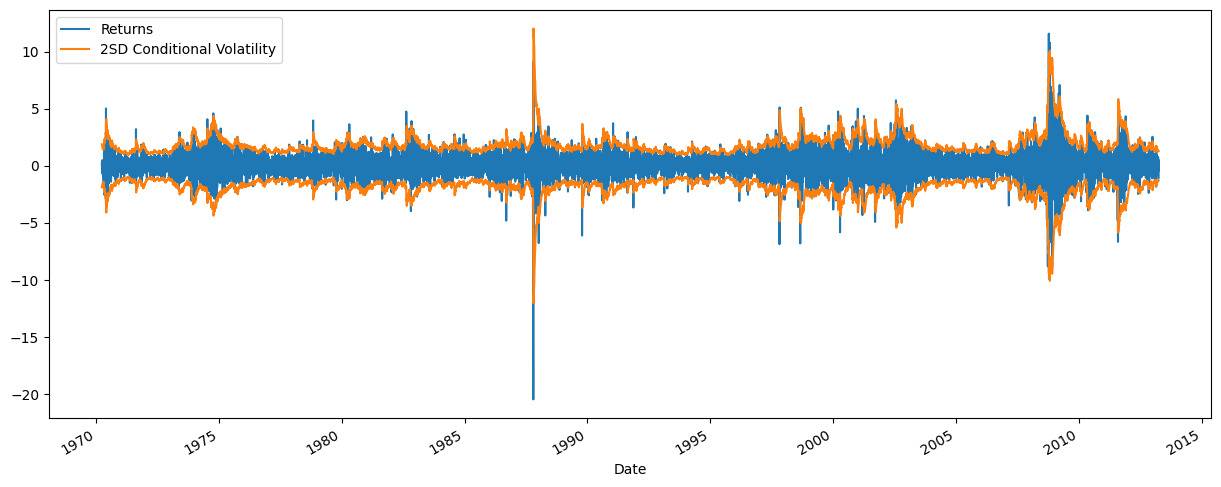

In [37]:
plt.subplots(figsize=(15, 6))

train_data.plot(label='Returns')

(2 * results_final.conditional_volatility).plot(color='C1',label='2SD Conditional Volatility')

(-2 * results_final.conditional_volatility).rename('').plot(color='C1')

plt.xlabel('Date')

plt.legend()
plt.show()

By the plot we can see that the model is fitting our data really well, to make sure that our model is appropriate we need to analyze the residuals.

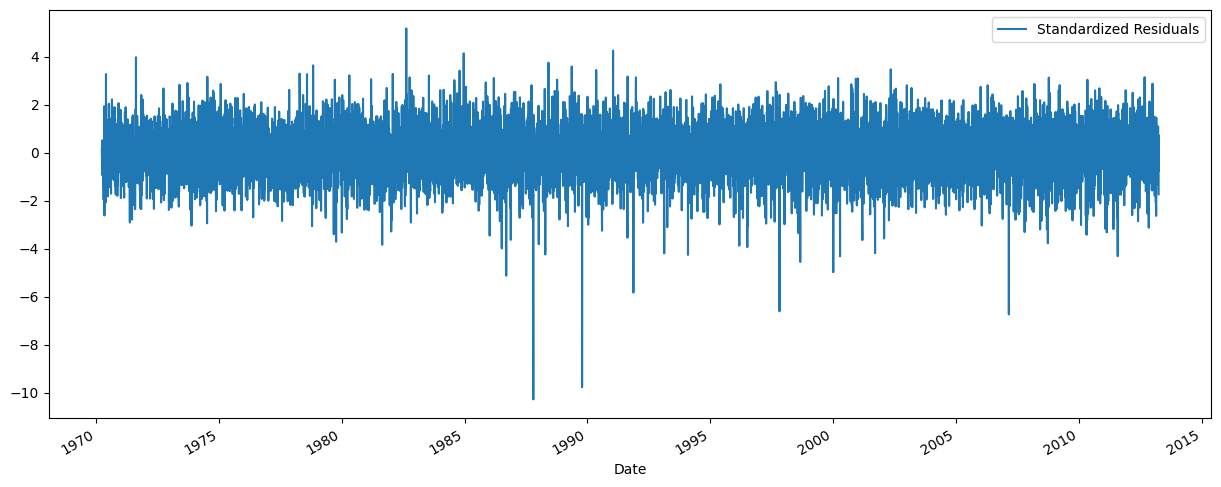

In [38]:
plt.subplots(figsize=(15, 6))

results_final.std_resid.plot(label='Standardized Residuals')

plt.xlabel('Date')
plt.legend()
plt.show()

The plot of the residuals looks good. The residuals have a consistent mean and spread over time.

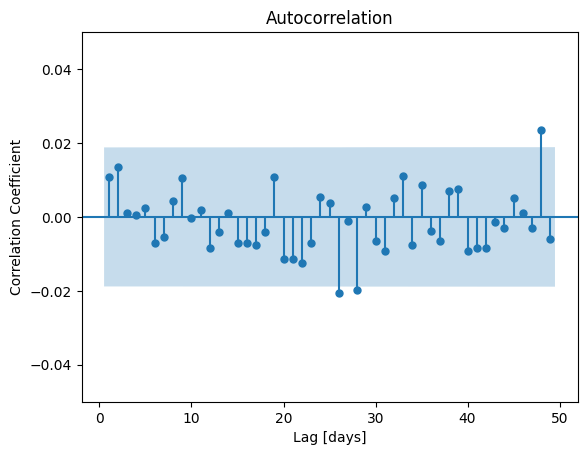

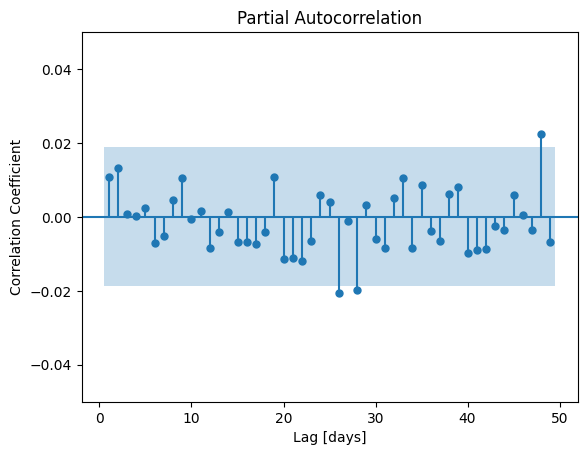

In [39]:
tsaplots.plot_acf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

tsaplots.plot_pacf(results_final.std_resid**2, lags=range(1,50))

plt.ylim([-0.05,0.05])
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()

The ACF and PACF of the residuals look like white noise another sign that our model is able to explain the data.

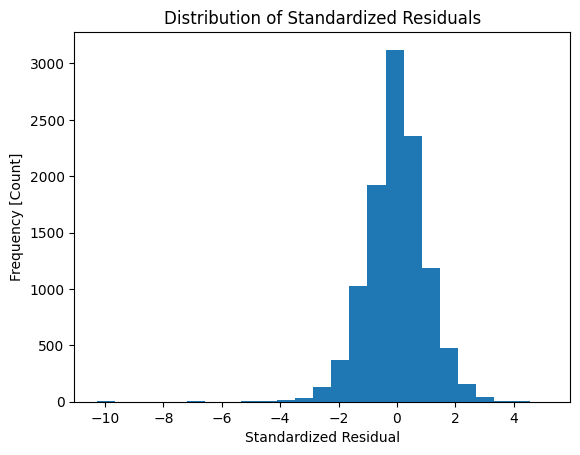

In [40]:
plt.hist(results_final.std_resid, bins=25)

plt.xlabel('Standardized Residual')
plt.ylabel('Frequency [Count]')

plt.title('Distribution of Standardized Residuals')
plt.show()

The histogram tells us that the residuals have a distribution simmilar to normal, to confirm this we will take a look at the density function compared to the density of a normal distribution.

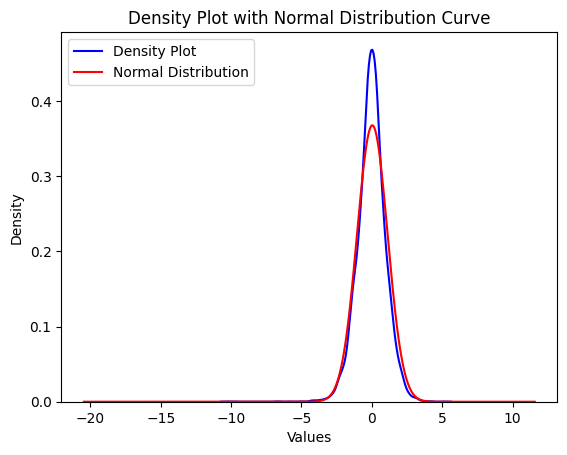

In [41]:
sns.kdeplot(results_final.std_resid, label='Density Plot', color='blue')
x = pd.Series(np.arange(min(returns), max(returns), 0.001))

# ??????
plt.plot(x, norm.pdf(x, loc=returns.mean(), scale=returns.std()), color='red', label='Normal Distribution')
plt.title('Density Plot with Normal Distribution Curve')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()

We can also look at the residuals over our fitted values and to a Q-Q plot of the residuals.

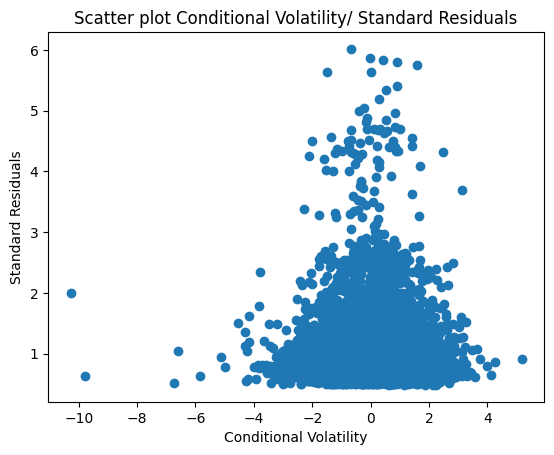

In [42]:
plt.scatter(x= results_final.std_resid, y= results_final.conditional_volatility)
plt.title('Scatter plot Conditional Volatility/ Standard Residuals')
plt.xlabel('Conditional Volatility')
plt.ylabel('Standard Residuals')
plt.show()

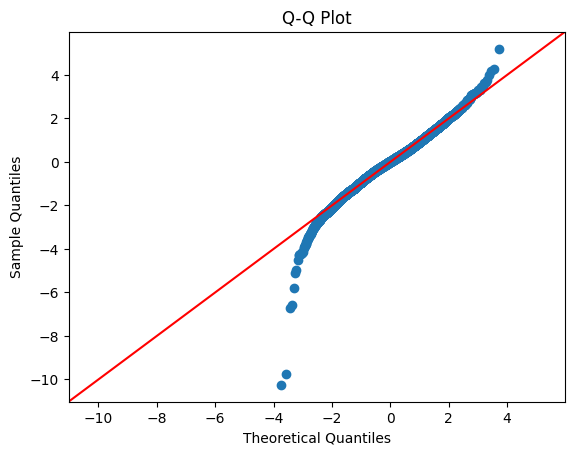

In [43]:
sm.qqplot(results_final.std_resid, line='45', fit=True)
plt.title('Q-Q Plot')
plt.show()

After analyzing this plots we can confidently say that the residuals of our model resemble white noise, a sign that our model is adequate for our data.

Finnaly lets take a look at the predicitons of our model

In [44]:
predictions = []

test_size = int(len(returns) *0.2)

for i in range(test_size):
    train_data_loop = returns.iloc[:-(test_size-i)]

    model = arch_model(train_data_loop,vol="GARCH",p=1,q=1)
    results_arch = model.fit(disp='off')

    forecasts = results_arch.forecast(horizon=1,reindex=False)
    next_pred = forecasts.variance.iloc[0,0] ** 0.5

    #train_data = pd.concat([train_data,pd.Series([next_pred])])
    
    predictions.append(next_pred)


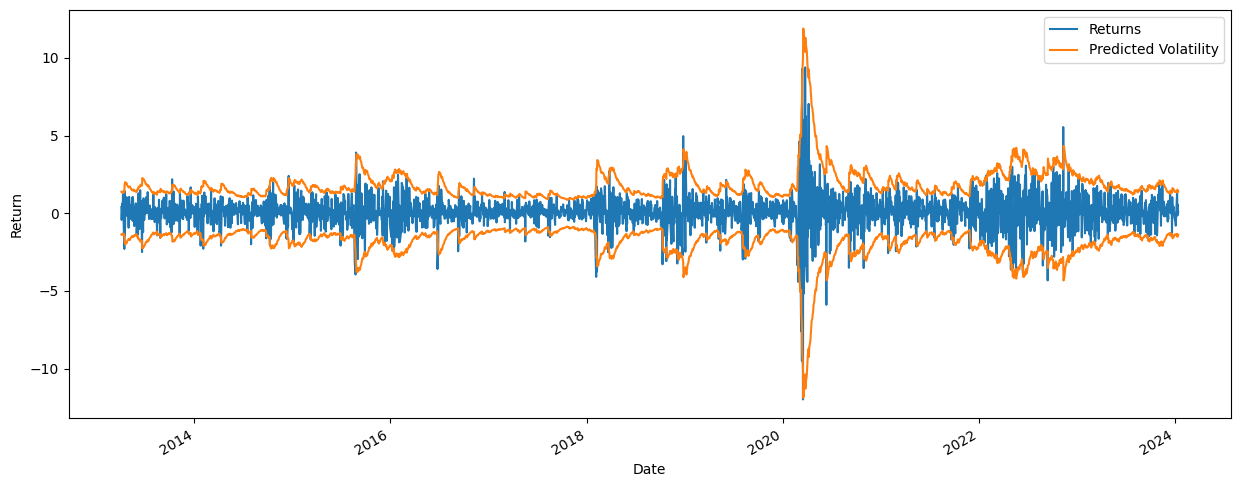

In [45]:
data_test_wfv = pd.Series(predictions, index=returns.tail(test_size).index)

plt.subplots(figsize=(15, 6))
returns.tail(test_size).plot( label="Returns")

(2 * data_test_wfv).plot(c="C1", label="Predicted Volatility")
(-2 * data_test_wfv).plot(c="C1")

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()

In [70]:
num_bootstrap_samples = 10

num_values = 10
table=[['observed','high','low']]
residuals =  results_final.std_resid

forecast_values = []

for _ in range(num_bootstrap_samples):
    bootstrap_sample = np.random.choice(residuals, size=len(residuals), replace=True)

    model_fit = arch_model(bootstrap_sample,vol='GARCH',p=1,q=1)
    model_fit = model_fit.fit(disp='off')

    forecast = model_fit.forecast(horizon=num_values).variance
    forecast_values.append(forecast)

mean_forecast = np.mean(forecast_values, axis=0)
lower_ci = np.percentile(forecast_values, 2.5, axis=0)
upper_ci = np.percentile(forecast_values, 97.5, axis=0)

for i in range(len(mean_forecast[0])):
    table.append([mean_forecast[0][i],upper_ci[0][i],lower_ci[0][i]])

print(tabulate(table, tablefmt="fancy_grid"))

╒════════════════════╤════════════════════╤════════════════════╕
│ observed           │ high               │ low                │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0021715423687736 │ 1.0300808863560436 │ 0.9822659008576413 │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0032045143060027 │ 1.0301254305586094 │ 0.9840444378107339 │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0032083924250255 │ 1.0301456156603088 │ 0.9840444378107339 │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0031676297227594 │ 1.0301547623752054 │ 0.9840444378107339 │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0031243671625523 │ 1.0301589070406918 │ 0.9840444378107339 │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0030818482086998 │ 1.0301607850438779 │ 0.9840444378107339 │
├────────────────────┼────────────────────┼────────────────────┤
│ 1.0030407496287017 │ 1.

The predictions shows us that the model was able to capture our data farily well, being able to represent periods of low or high volatility.

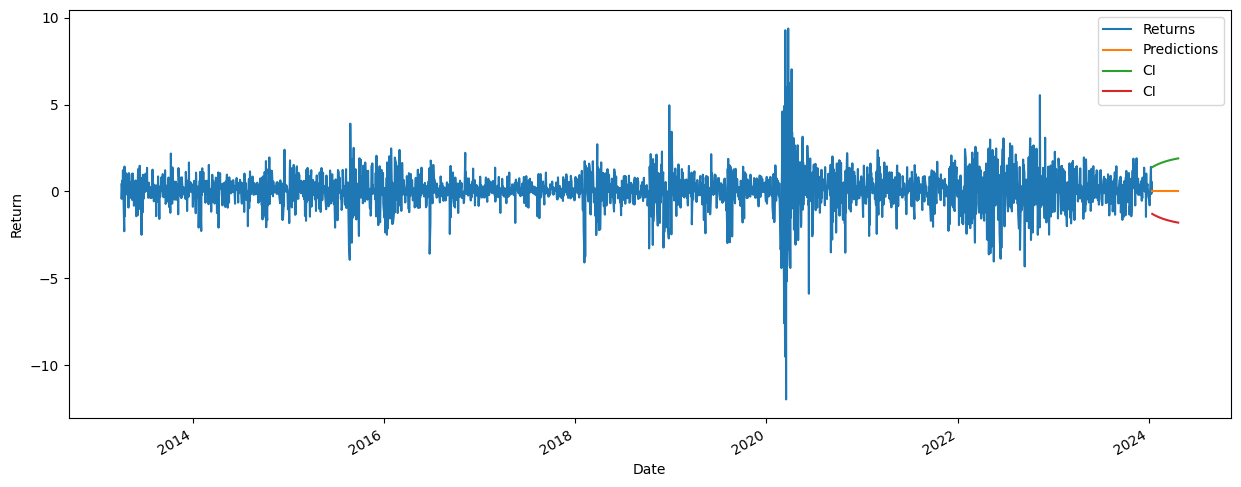

In [47]:
h = 100

forecasts = results_final.forecast(horizon=h)
date = returns.tail(1).index
confidence_interval = 1.96 * np.sqrt(forecasts.variance)

new = pd.Series()
ci_upper = pd.Series()
ci_lower = pd.Series()
for i in range(h):
    date = date + timedelta(1)
    if len(new) != 0:
        new = pd.concat([new,pd.Series(forecasts.mean.iloc[0,i],index=date)])
        ci_upper = pd.concat([ci_upper,pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)])
        ci_lower = pd.concat([ci_lower,pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i] ,index=date)])
    else: 
        new = pd.Series(forecasts.mean.iloc[0,i],index=date)
        ci_upper = pd.Series(confidence_interval.iloc[0,i] + forecasts.mean.iloc[0,i],index=date)
        ci_lower = pd.Series(forecasts.mean.iloc[0,i] - confidence_interval.iloc[0,i],index=date)
        

plt.subplots(figsize=(15, 6))

test_data.plot(label='Returns')
new.plot(label='Predictions')
ci_upper.plot(label='CI')
ci_lower.plot(label='CI')

plt.xlabel("Date")
plt.ylabel("Return")

plt.legend()
plt.show()